## Findings so far.
### Grouping on date, I found the following:
- Markdowns are mostly missing in the first half of the data, from 2011-11-11 there are barely any missing values (only 7 missing for MarkDown2, the rest is 100%)
- Weekly Sales are missing from 2012-10-26 onwards
- CPI and Unemployment are missing from 2013-05-03 onwards

So, from 2011-11-11 until 2013-05-03 there is Markdown data, so atleast for a full year. We can check differences between e.g. 2011-11-11 and 2012-11-11 (may need to convert to week numbers). From here we can potentially work to a substitution for the missing values, taking an average for example. Hopefully differences are not too big. Don't forget about markdown2.

Then we could predict sales based on markdowns + CPI + unemployment + fuel price + IsHoliday + temperature for the period 2012-10-26 until 2013-05-03 atleast. There will be no missing values until that date.

From there on use linear regression + random forest. Train/test split 80/20 over the period until 2012-10-26. Then predict values for 2012-10-26 until 2013-05-03.


Other ideas: 
- take best and worst performing store or department and see how they differ in Markdown strategy. 
- cluster on temperature or fuel price etc. to see if it affects sales in any way. Maybe with only holiday = TRUE
-  

And, what do we do with the fact that "This weeks, including these holidays, are weighted five times higher in the evaluation then non-holiday weeks." 



In [26]:
# importing necessary libraries
import os
import numpy as np   
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [27]:
# Copy and paste the path of the directory that holds your data to the path variable
path = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"
os.chdir(path)
print(os.path)

<module 'ntpath' from 'c:\\Users\\blk\\AppData\\Local\\Programs\\Python\\Python39\\lib\\ntpath.py'>


In [28]:
# Loading data
features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

In [29]:
features.info()
features.head()
features.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,26/07/2013,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [30]:
features.Temperature.describe()

count    8190.000000
mean       59.356198
std        18.678607
min        -7.290000
25%        45.902500
50%        60.710000
75%        73.880000
max       101.950000
Name: Temperature, dtype: float64

In [31]:
features.Fuel_Price.describe()

count    8190.000000
mean        3.405992
std         0.431337
min         2.472000
25%         3.041000
50%         3.513000
75%         3.743000
max         4.468000
Name: Fuel_Price, dtype: float64

In [32]:
holiday_count = features['IsHoliday'].sum()
print(holiday_count)


585


In [33]:
print(
    features.MarkDown5.describe(), '\n',
    features.MarkDown5.isna().sum()
)

count      4050.000000
mean       4132.216422
std       13086.690278
min        -185.170000
25%        1440.827500
50%        2727.135000
75%        4832.555000
max      771448.100000
Name: MarkDown5, dtype: float64 
 4140


In [34]:
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [35]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [36]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

In [37]:
print(features.columns)

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')


In [38]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [39]:
features = pd.merge(features, stores, on=["Store"], how='left')
features.head(20)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315


In [55]:
features_grouped = features.groupby("Date").agg({"Temperature": "mean",
                                                     "Fuel_Price": "mean",
                                                     "CPI": "mean",
                                                     "Unemployment": "mean",
                                                      "IsHoliday": "min",
                                                      "MarkDown1": "mean",
                                                      "MarkDown2": "mean",
                                                      "MarkDown3": "mean",
                                                      "MarkDown4": "mean",
                                                      "MarkDown5": "mean"})
print(
    features_grouped.shape, '\n',
    features_grouped.head(3)
)

print(features_grouped.index)

(182, 10) 
             Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
Date                                                                       
2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2010-02-19    37.719778    2.672067  167.871686      8.619311      False   

            MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  
Date                                                               
2010-02-05        NaN        NaN        NaN        NaN        NaN  
2010-02-12        NaN        NaN        NaN        NaN        NaN  
2010-02-19        NaN        NaN        NaN        NaN        NaN  
DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2013-05-24', '2013-05-31', '2013-06-07', '2013-

In [56]:
print(
    features_grouped[92:].MarkDown5.isna().sum(), '\n',
    features_grouped[90:95], '\n',
    features_grouped[-1:]
)

0 
             Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
Date                                                                       
2011-10-28    56.468889    3.541022  173.046419      7.804222      False  \
2011-11-04    49.200000    3.522044  173.123477      7.804222      False   
2011-11-11    49.112444    3.488711  173.200535      7.804222      False   
2011-11-18    52.191556    3.487400  173.300470      7.804222      False   
2011-11-25    49.627556    3.434311  173.409555      7.804222       True   

               MarkDown1    MarkDown2     MarkDown3    MarkDown4    MarkDown5  
Date                                                                           
2011-10-28           NaN          NaN           NaN          NaN          NaN  
2011-11-04           NaN          NaN           NaN          NaN          NaN  
2011-11-11  10732.220667  9031.857778    301.183864  4122.438378  4946.894444  
2011-11-18   5998.128000   650.518864    114.090250   815.50289

# FUN fact, almost all NaN markdown values are before and including 2011-11-04, after this date, only markdown 2 has 7 missing values, the rest 0.

So, we have basically all markdown values available from 2011-11-11 onwards

In [42]:
print(features_grouped.MarkDown2.isna().sum())

99


In [57]:
print(features_grouped.columns)


Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'],
      dtype='object')


In [58]:
# Count NaN values for 'CPI'
nan_cpi_count = features_grouped['CPI'].isna().sum()

print(f"Number of NaN values in 'CPI': {nan_cpi_count}")

print(features_grouped[-20:])

Number of NaN values in 'CPI': 13
            Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
Date                                                                       
2013-03-15    48.728000    3.751467  177.740876      6.876444      False  \
2013-03-22    49.300889    3.747267  177.803327      6.876444      False   
2013-03-29    46.997111    3.731667  177.865778      6.876444      False   
2013-04-05    52.718222    3.704644  177.928229      6.719244      False   
2013-04-12    55.050222    3.671044  177.990680      6.719244      False   
2013-04-19    56.745556    3.618156  177.990680      6.719244      False   
2013-04-26    55.033778    3.586022  177.990680      6.719244      False   
2013-05-03    61.780444    3.536933         NaN           NaN      False   
2013-05-10    62.092444    3.542822         NaN           NaN      False   
2013-05-17    66.612889    3.604333         NaN           NaN      False   
2013-05-24    69.696889    3.649556         NaN       

In [59]:
# Filter rows where 'CPI' has NaN values
nan_cpi_rows = features_grouped[features_grouped['CPI'].isna()]

# Display the dates (indices) with NaN values for 'CPI'
print(nan_cpi_rows.index)


DatetimeIndex(['2013-05-03', '2013-05-10', '2013-05-17', '2013-05-24',
               '2013-05-31', '2013-06-07', '2013-06-14', '2013-06-21',
               '2013-06-28', '2013-07-05', '2013-07-12', '2013-07-19',
               '2013-07-26'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [60]:
sales_grouped = sales.groupby("Date").agg({"Weekly_Sales" : "sum"})
sales_grouped["Weekly_Sales"] = (sales_grouped["Weekly_Sales"] / 1e6).astype(int)
sales_grouped.tail()

,Weekly_Sales
Date,
2012-09-28,43
2012-10-05,47
2012-10-12,46
2012-10-19,45
2012-10-26,45


In [61]:
# now: create a merged dataframe
data_datewise = pd.merge(features_grouped, sales_grouped, on=["Date"], how="left").reset_index()
data_datewise.tail()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Weekly_Sales
177,2013-06-28,79.871111,3.629400,NaN,NaN,False,4905.673333,766.902703,23.950385,3831.422703,3771.952889,NaN
178,2013-07-05,79.655778,3.583533,NaN,NaN,False,8197.936444,2192.764054,626.819070,8357.932564,2389.641333,NaN
179,2013-07-12,80.798667,3.568111,NaN,NaN,False,3962.768444,1259.823947,71.435814,2322.072703,2891.560222,NaN
180,2013-07-19,79.268667,3.683444,NaN,NaN,False,2607.699333,924.923158,142.733000,1034.775526,1893.073333,NaN
181,2013-07-26,78.037333,3.734444,NaN,NaN,False,896.289091,795.463947,41.174167,186.227838,1623.047111,NaN


# Apparently there is no more sales data from index 142 (2012-10-26) onwards, CPI and Unemployment are not available as of 169 onwards (2013-05-03)
## seems reasonable to continue with a slice of the data up to and including 142

In [63]:
print(
    features_grouped.columns,
    features_grouped.index
)

Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'],
      dtype='object') DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2013-05-24', '2013-05-31', '2013-06-07', '2013-06-14',
               '2013-06-21', '2013-06-28', '2013-07-05', '2013-07-12',
               '2013-07-19', '2013-07-26'],
              dtype='datetime64[ns]', name='Date', length=182, freq=None)


In [64]:
features_grouped['Index'] = range(1, len(features_grouped) + 1)
ifeatures_grouped = features_grouped.reset_index()
print(
    ifeatures_grouped.head(),
)

        Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0 2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
1 2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2 2010-02-19    37.719778    2.672067  167.871686      8.619311      False   
3 2010-02-26    39.243556    2.683933  167.909657      8.619311      False   
4 2010-03-05    42.917333    2.731200  167.947628      8.619311      False   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  Index  
0        NaN        NaN        NaN        NaN        NaN      1  
1        NaN        NaN        NaN        NaN        NaN      2  
2        NaN        NaN        NaN        NaN        NaN      3  
3        NaN        NaN        NaN        NaN        NaN      4  
4        NaN        NaN        NaN        NaN        NaN      5  


In [65]:
ifeatures_grouped['Week'] = ifeatures_grouped["Date"].dt.isocalendar().week
print(ifeatures_grouped.head())

        Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0 2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
1 2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2 2010-02-19    37.719778    2.672067  167.871686      8.619311      False   
3 2010-02-26    39.243556    2.683933  167.909657      8.619311      False   
4 2010-03-05    42.917333    2.731200  167.947628      8.619311      False   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  Index  Week  
0        NaN        NaN        NaN        NaN        NaN      1     5  
1        NaN        NaN        NaN        NaN        NaN      2     6  
2        NaN        NaN        NaN        NaN        NaN      3     7  
3        NaN        NaN        NaN        NaN        NaN      4     8  
4        NaN        NaN        NaN        NaN        NaN      5     9  


In [66]:
value = 5
rows_with_value = ifeatures_grouped[ifeatures_grouped['Week'] == value]
print(rows_with_value)

          Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0   2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
52  2011-02-04    30.480889    3.134822  169.288145      8.291200      False   
104 2012-02-03    44.804444    3.451689  174.473324      7.508333      False   
156 2013-02-01    42.755778    3.394311  177.372908      6.876444      False   

        MarkDown1    MarkDown2   MarkDown3     MarkDown4    MarkDown5  Index   
0             NaN          NaN         NaN           NaN          NaN      1  \
52            NaN          NaN         NaN           NaN          NaN     53   
104  36093.593556  2812.054889  142.414000  29920.769302  5950.383333    105   
156  12085.631111  1075.846000  256.236512  19564.539024  2420.377333    157   

     Week  
0       5  
52      5  
104     5  
156     5  


### Impute MarkDown 1-5 NaN values with average of available values in the same week over different years.

In [67]:
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = ifeatures_grouped.groupby('Week')[col].transform('mean')
    ifeatures_grouped[col].fillna(weekly_avg, inplace=True)

print(ifeatures_grouped)

# can't impute all values for MarkDown2 , dropping Markdown2.

ifeatures_grouped = ifeatures_grouped.drop('MarkDown2', axis = 1)
ifeatures_grouped.columns

          Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0   2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
1   2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2   2010-02-19    37.719778    2.672067  167.871686      8.619311      False   
3   2010-02-26    39.243556    2.683933  167.909657      8.619311      False   
4   2010-03-05    42.917333    2.731200  167.947628      8.619311      False   
..         ...          ...         ...         ...           ...        ...   
177 2013-06-28    79.871111    3.629400         NaN           NaN      False   
178 2013-07-05    79.655778    3.583533         NaN           NaN      False   
179 2013-07-12    80.798667    3.568111         NaN           NaN      False   
180 2013-07-19    79.268667    3.683444         NaN           NaN      False   
181 2013-07-26    78.037333    3.734444         NaN           NaN      False   

        MarkDown1    MarkDown2   MarkDo

Index(['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
       'MarkDown1', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Index', 'Week'],
      dtype='object')

In [68]:
df_datewise = pd.merge(ifeatures_grouped, sales_grouped, on=['Date'], how='left')
print(
    df_datewise.tail()
)

          Date  Temperature  Fuel_Price  CPI  Unemployment  IsHoliday   
177 2013-06-28    79.871111    3.629400  NaN           NaN      False  \
178 2013-07-05    79.655778    3.583533  NaN           NaN      False   
179 2013-07-12    80.798667    3.568111  NaN           NaN      False   
180 2013-07-19    79.268667    3.683444  NaN           NaN      False   
181 2013-07-26    78.037333    3.734444  NaN           NaN      False   

       MarkDown1   MarkDown3    MarkDown4    MarkDown5  Index  Week   
177  4905.673333   23.950385  3831.422703  3771.952889    178    26  \
178  8197.936444  626.819070  8357.932564  2389.641333    179    27   
179  3962.768444   71.435814  2322.072703  2891.560222    180    28   
180  2607.699333  142.733000  1034.775526  1893.073333    181    29   
181   896.289091   41.174167   186.227838  1623.047111    182    30   

     Weekly_Sales  
177           NaN  
178           NaN  
179           NaN  
180           NaN  
181           NaN  


In [69]:
# data = df_datewise[0:143]
data = df_datewise
data = data.drop('Index', axis = 1)
print(
    data.head(),
    data.columns  
      )

data.isna().sum()

        Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0 2010-02-05    34.037333    2.717844  167.730885      8.619311      False  \
1 2010-02-12    34.151333    2.694022  167.825608      8.619311       True   
2 2010-02-19    37.719778    2.672067  167.871686      8.619311      False   
3 2010-02-26    39.243556    2.683933  167.909657      8.619311      False   
4 2010-03-05    42.917333    2.731200  167.947628      8.619311      False   

      MarkDown1   MarkDown3     MarkDown4    MarkDown5  Week  Weekly_Sales  
0  24089.612333  199.325256  24742.654163  4185.380333     5          49.0  
1  29880.900556  200.033519  19646.377135  5089.147556     6          48.0  
2  12536.748111   62.672919   7040.314331  5646.276000     7          48.0  
3   8504.312444   24.218426   2881.930628  4458.685000     8          43.0  
4  11293.039000   21.398405   6237.467212  2911.005778     9          46.0   Index(['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'I

Date             0
Temperature      0
Fuel_Price       0
CPI             13
Unemployment    13
IsHoliday        0
MarkDown1        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
Week             0
Weekly_Sales    39
dtype: int64

## Have to decide how to impute CPI and Unemployment, may be better to continue the line instead of taking the mean (look at graph below)

In [70]:
# Codes for forward filling the missing values 
data['CPI'].fillna(method='ffill', inplace=True)
data['Unemployment'].fillna(method='ffill', inplace=True)

# Turning IsHoliday to binary value
data.IsHoliday = data.IsHoliday.map({True:1, False:0})

print(
    data.head(), '\n',
    data.isna().sum()
)

        Date  Temperature  Fuel_Price         CPI  Unemployment  IsHoliday   
0 2010-02-05    34.037333    2.717844  167.730885      8.619311          0  \
1 2010-02-12    34.151333    2.694022  167.825608      8.619311          1   
2 2010-02-19    37.719778    2.672067  167.871686      8.619311          0   
3 2010-02-26    39.243556    2.683933  167.909657      8.619311          0   
4 2010-03-05    42.917333    2.731200  167.947628      8.619311          0   

      MarkDown1   MarkDown3     MarkDown4    MarkDown5  Week  Weekly_Sales  
0  24089.612333  199.325256  24742.654163  4185.380333     5          49.0  
1  29880.900556  200.033519  19646.377135  5089.147556     6          48.0  
2  12536.748111   62.672919   7040.314331  5646.276000     7          48.0  
3   8504.312444   24.218426   2881.930628  4458.685000     8          43.0  
4  11293.039000   21.398405   6237.467212  2911.005778     9          46.0   
 Date             0
Temperature      0
Fuel_Price       0
CPI       

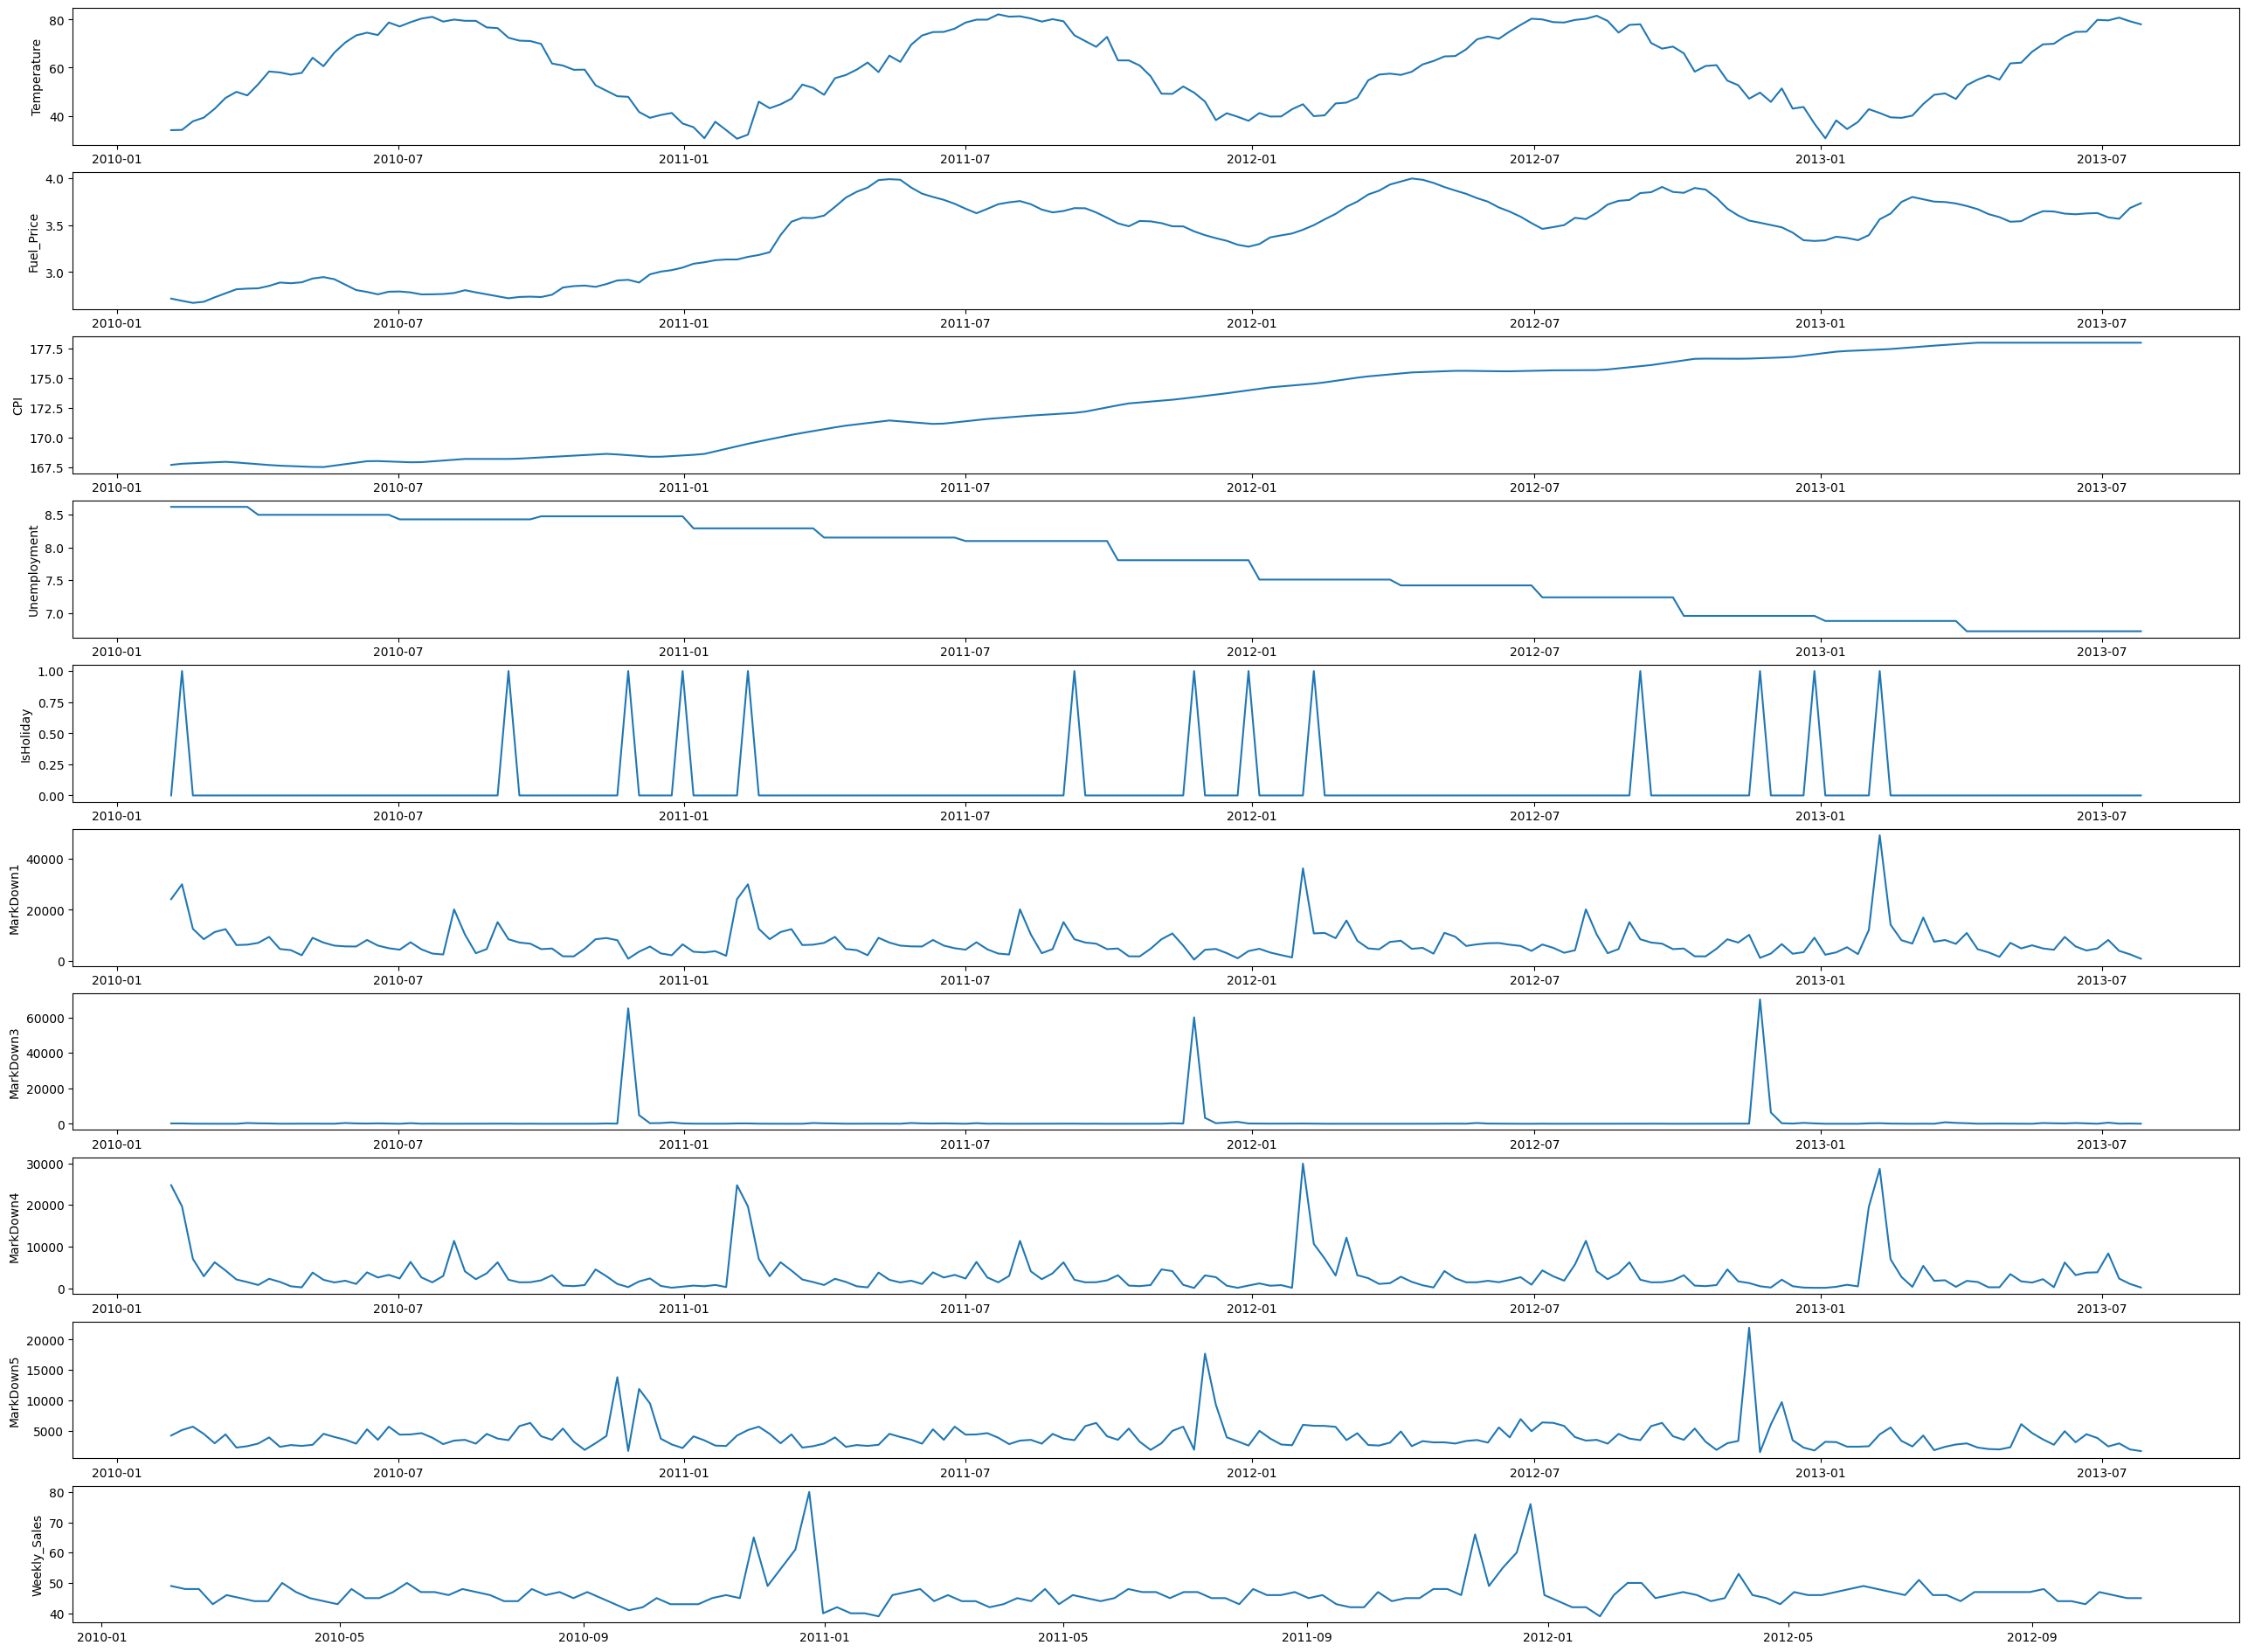

In [75]:
# List of columns you want to include
columns_to_include = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'MarkDown1', 'MarkDown3','MarkDown4','MarkDown5', 'Weekly_Sales']  # Replace with your actual column names

fig = plt.figure(figsize=(32, 24))
count_columns_ex_date = len(columns_to_include)
for idx, col in enumerate(columns_to_include):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(data["Date"], data[col])
    plt.ylabel(col)
    

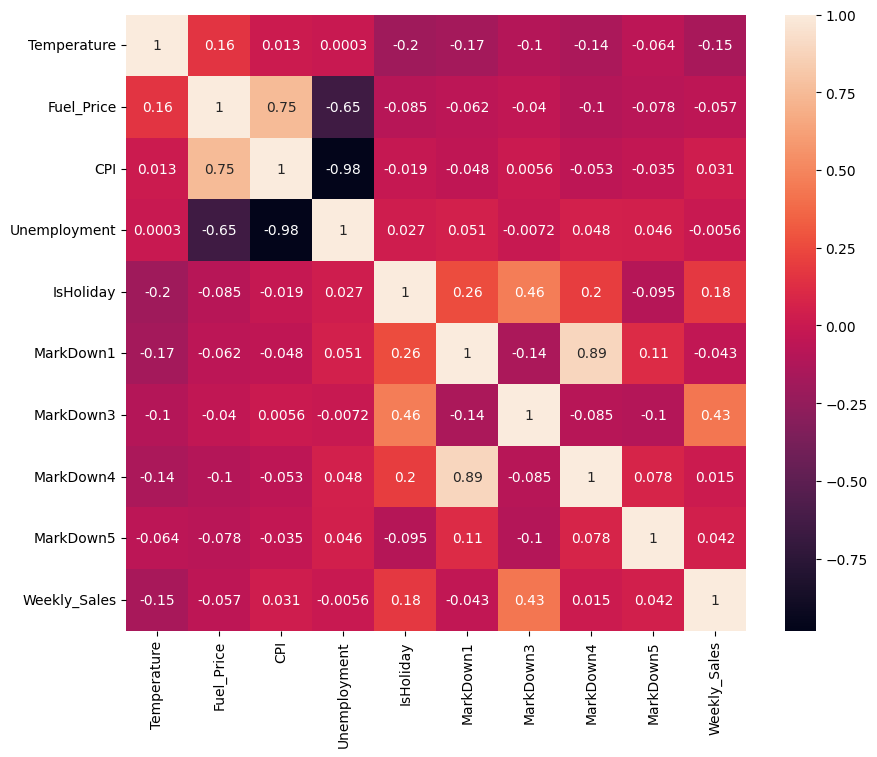

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(data[columns_to_include].corr(),annot=True)
plt.show()

In [78]:
# Set 'Date' as the index
# idata = data.set_index('Date', inplace=True)
data.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5,Week,Weekly_Sales
0,2010-02-05,34.037333,2.717844,167.730885,8.619311,0,24089.612333,199.325256,24742.654163,4185.380333,5,49.0
1,2010-02-12,34.151333,2.694022,167.825608,8.619311,1,29880.900556,200.033519,19646.377135,5089.147556,6,48.0
2,2010-02-19,37.719778,2.672067,167.871686,8.619311,0,12536.748111,62.672919,7040.314331,5646.276000,7,48.0
3,2010-02-26,39.243556,2.683933,167.909657,8.619311,0,8504.312444,24.218426,2881.930628,4458.685000,8,43.0
4,2010-03-05,42.917333,2.731200,167.947628,8.619311,0,11293.039000,21.398405,6237.467212,2911.005778,9,46.0


      Weekly_Sales
year              
2010        2264.0
2011        2419.0
2012        1981.0
2013           0.0


Text(0, 0.5, 'Sales')

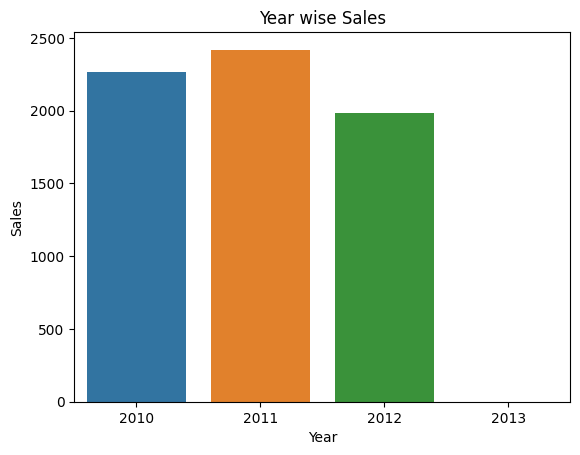

In [79]:
data_sales_year = data.groupby(data['Date'].dt.isocalendar().year).agg({"Weekly_Sales":"sum"})
print(
    data_sales_year
)
sns.barplot(x=data_sales_year.index, y=data_sales_year.Weekly_Sales)
plt.title("Year wise Sales")
plt.xlabel("Year")
plt.ylabel("Sales")

### Final line, saving data for model use

In [80]:
data.to_csv('A2_data_clean.csv')